# Part 3 — Ranking and Filtering

Marc Bosch Manzano u215231<br>
Chris Matienzo Chilo u198726<br>
Àlex Roger Moya u199765<br>

## Preliminary Section

### Import packages and modules

In [1]:
import os
import pandas as pd
from importlib import reload
from gensim.models import Word2Vec


import solution.processing
import solution.model           
import solution.visualization

reload(solution.processing)
reload(solution.model)
reload(solution.visualization)

from solution.model import Ranking, BM25, Custom, WordVector, TFIDF
from solution.visualization import RankingVisualization
from solution.processing import build_terms_str

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Usuari\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Usuari\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Usuari\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Usuari\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Data initialization

In [2]:
input_directory = "../IRWA-2025-data/"
input_name = "fashion_products_dataset_processed.csv"
input_path = os.path.join(input_directory, input_name)
df_fashion_products = pd.read_csv(input_path, sep=",")

In [3]:
pd.set_option('display.max_colwidth', 15)
print("FASHION PRODUCTS DATAFRAME")
display(df_fashion_products.sample(5))
print()

print("FASHION PRODUCTS DATAFRAME: DOCUMENT COLUMN")
pd.set_option('display.max_colwidth', 100)
display(df_fashion_products.sample(5)["document"])


FASHION PRODUCTS DATAFRAME


,pid,title,description,brand,category,sub_category,seller,out_of_stock,selling_price,discount,...,product_details_Style Code,product_details_Pattern,product_details_Fabric Care,product_details_Suitable For,product_details_Sleeve,product_details_Pack of,product_details_Type,product_details_Ideal For,product_details_Fit,document
11355,SHTFV5G2VTM...,fit camoufl...,NaN,ECKO Unl,Clothing an...,Topwear,SandSMarketing,False,736.0,33.0,...,KSH002350,Military Ca...,Gentle Mach...,Western Wear,Full Sleeve,1,NaN,NaN,Slim,cotton clot...
25783,TSHFDCH4UQA...,grey print ...,tee graphic...,Pu,Clothing an...,Topwear,Tayab Manch...,False,844.0,35.0,...,85414503,Printed,Do not Iron...,Western Wear,Half Sleeve,1,Round Neck,Men,Regular,graphic cot...
3955,TSHFZ6CUH2G...,graphic pri...,meet cold h...,Mylifestyle...,Clothing an...,Topwear,Mylifestyle...,False,399.0,50.0,...,MB-Dost-Muj...,Graphic Print,Do not Iron...,Western Wear,Half Sleeve,1,Round Neck,Men,Regular,meet graphi...
2068,TSHF2ZF4CHZ...,polo maroon...,NaN,REEB,Clothing an...,Topwear,RetailNet,False,1176.0,1.0,...,CX0393RCHMGM,Solid,Machine was...,Western Wear,Half Sleeve,1,Polo Neck,Men,Regular,retailnet c...
20761,SHTFWP8C4GR...,fit collar ...,NaN,Mett,Clothing an...,Topwear,METTLEAPPARELS,False,909.0,35.0,...,M-157W20-BL...,Checkered,Hand wash,Western Wear,Full Sleeve,1,NaN,NaN,Regular,collar cott...



FASHION PRODUCTS DATAFRAME: DOCUMENT COLUMN


13945    cotton solid cloth pack men white wear regular blend per sleev wash maroon topwear half machin n...
11959    collar cotton solid cloth full design unl ecko wear fit eksh self blend women filafil slim woven...
1460     collar cotton solid cloth pack j hand wear regular fit blend sg- -r sleev global wash topwear ha...
17305    grey mc normal women solid bottomwear waash track cloth colou mountaincolour machin hosieri pant...
2446     cufflink technolog someon cloth design set forget choo tripin pair silver better add bring apart...
Name: document, dtype: object

## Activities

### Activity 1: Ranking Algorithms Comparison

You’re asked to provide 3 different ways of ranking: 
a) TF-IDF + cosine similarity: Classical scoring, which we have also seen during the 
practical labs <br>
b) BM25  <br>
c) Your Score: Here, the task is to create a new score. (Be creative, think about 
what factors could make a document more relevant to a query and include them 
in your formula.) 

Explain how the ranking differs when using TF-IDF and BM25, and think about the pros and  cons  of  using  each  of  them.  Regarding your own score, justify the choice of the score (pros and cons). HINT: Look into numerical fields that each record has to build your score.

In [4]:
documents = df_fashion_products.set_index("pid")["document"]
static_scores = df_fashion_products.set_index("pid")["average_rating"]
query = pd.Series("men slim jean blue").apply(build_terms_str)

In [5]:
visualizator = RankingVisualization(documents, static_scores, queries=query)

In [6]:
visualizator.print_comparisons_df(sort_by="TF-IDF Rank", topK=10, head=10)
visualizator.print_comparisons_df(sort_by="BM25 Rank", topK=10, head=10)
visualizator.print_comparisons_df(sort_by="Custom Rank", topK=10, head=10)


--- Top Document Rank Comparison (Sorted by BM25 Rank) ---


,Document ID,TF-IDF Rank,TF-IDF Score,BM25 Rank,BM25 Score,Custom Rank,Custom Score
0,JEAFSGSYEAFCYHEE,1.0,0.562027,1.0,12.740358,NaN,NaN
1,JEAFTGSGTYKZGAEZ,2.0,0.562027,2.0,12.740358,NaN,NaN
2,JEAFRAQXEKGUPNUN,3.0,0.508528,NaN,NaN,NaN,NaN
3,JEAF65G3GPYHV7XW,4.0,0.499140,10.0,12.136830,5.0,1.339398
4,JEAFEKQZ4C2Z6GCX,5.0,0.451014,NaN,NaN,NaN,NaN
5,JEAFEKQZWYPVGYCJ,6.0,0.451014,NaN,NaN,NaN,NaN
6,JEAFEKQZQPYHHVGS,7.0,0.451014,NaN,NaN,NaN,NaN
7,JEAFEN3WVGHTJPY9,8.0,0.449970,7.0,12.331551,1.0,1.664979
8,JEAFM3Y9ZNMVG6ZM,9.0,0.443452,NaN,NaN,NaN,NaN
9,JEAFJV3HMBB9YA7G,10.0,0.439425,4.0,12.532621,NaN,NaN



--- Top Document Rank Comparison (Sorted by BM25 Rank) ---


,Document ID,TF-IDF Rank,TF-IDF Score,BM25 Rank,BM25 Score,Custom Rank,Custom Score
0,JEAFSGSYEAFCYHEE,1.0,0.562027,1.0,12.740358,NaN,NaN
1,JEAFTGSGTYKZGAEZ,2.0,0.562027,2.0,12.740358,NaN,NaN
2,JEAFKWR3FX9NH2V6,NaN,NaN,3.0,12.532621,NaN,NaN
3,JEAFJV3HMBB9YA7G,10.0,0.439425,4.0,12.532621,NaN,NaN
4,JEAFESND4QWQUBZD,NaN,NaN,5.0,12.532621,NaN,NaN
5,JEAFESNEYAHAGPNH,NaN,NaN,6.0,12.532621,NaN,NaN
6,JEAFEN3WVGHTJPY9,8.0,0.449970,7.0,12.331551,1.0,1.664979
7,JEAFESNDTQCXGKAJ,NaN,NaN,8.0,12.331551,NaN,NaN
8,JEAFV8WURBM7PGYT,NaN,NaN,9.0,12.136830,NaN,NaN
9,JEAF65G3GPYHV7XW,4.0,0.499140,10.0,12.136830,5.0,1.339398



--- Top Document Rank Comparison (Sorted by BM25 Rank) ---


,Document ID,TF-IDF Rank,TF-IDF Score,BM25 Rank,BM25 Score,Custom Rank,Custom Score
0,JEAFEN3WVGHTJPY9,8.0,0.44997,7.0,12.331551,1.0,1.664979
1,JEAF8S4GGRU9VY46,NaN,NaN,NaN,NaN,2.0,1.495969
2,JEAEQ4R7WJSPGMHN,NaN,NaN,NaN,NaN,3.0,1.440016
3,JEAEKSCH3EXCGUEF,NaN,NaN,NaN,NaN,4.0,1.377383
4,JEAF65G3GPYHV7XW,4.0,0.49914,10.0,12.136830,5.0,1.339398
5,TSHE6WQC3WHWXNPZ,NaN,NaN,NaN,NaN,6.0,1.312848
6,BZRFUXVMEZUPAFFB,NaN,NaN,NaN,NaN,7.0,1.305993
7,JEAEKMCHWJJVUPQE,NaN,NaN,NaN,NaN,8.0,1.303384
8,JEAFDWG9K7KPKHS8,NaN,NaN,NaN,NaN,9.0,1.291990
9,SHTF98P88Z6WHRQJ,NaN,NaN,NaN,NaN,10.0,1.270371


In [7]:
visualizator.get_number_of_matchings_heat_map(topK=10)

,BM25 Rank,Custom Rank,TF-IDF Rank
BM25 Rank,10,2,5
Custom Rank,2,10,2
TF-IDF Rank,5,2,10


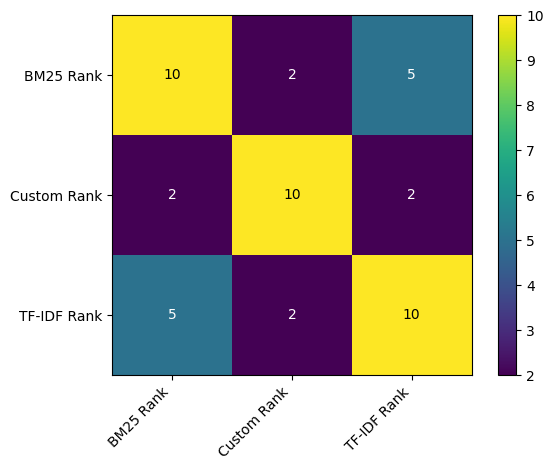

In [8]:
visualizator.plot_number_of_matchings_heat_map(topK=10)

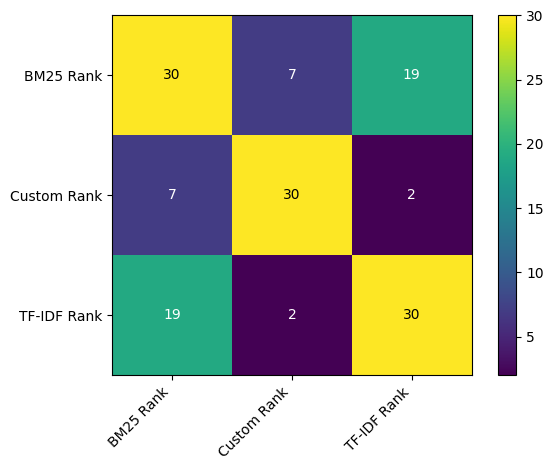

In [9]:
visualizator.plot_number_of_matchings_heat_map(topK=30)

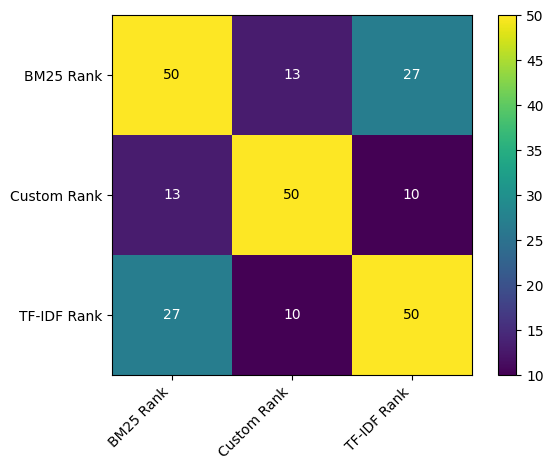

In [10]:
visualizator.plot_number_of_matchings_heat_map(topK=50)

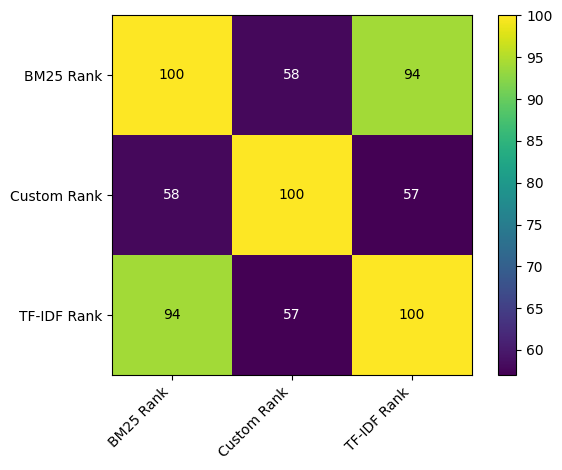

In [11]:
visualizator.plot_number_of_matchings_heat_map(topK=100)

<i>

</i>

### Activity 2: Word to Vector Implementation

Implement word2vec + cosine ranking score. Return a top-20 list of documents for each of  the  5  queries  defined  in  the  Part  2  of  your  project, using search and word2vec + cosine similarity ranking. 
   
To represent a piece of text using word2vec, we create a single vector that represents the entire text. This vector has the same number of dimensions as the word vectors and is calculated by averaging the vectors of all words in the text.

In [12]:
TOP_K = 20

queries = pd.Series([
    "slim men dark blue jeans",
    "adidas jacket",
    "women cotton dress",
    "black leather bag",
    "discount sport shoes"
]).apply(build_terms_str)

word2vec = Word2Vec(
    vector_size=50,
    window=5,
    min_count=2,
    workers=4,
    sg=0
)

In [13]:
word_vector_model = WordVector(documents, queries, word2vec)

In [14]:
scores_df = word_vector_model.get_scores_df(
    topK=TOP_K,
    boolean_filter=True
)

visualizator.print_query_rankings(scores_df, queries)

QUERY SCORES
=== query 0: slim men dark blue jean ===


,document_id,document_text,score
0,JEAFJV3HMBB9YA7G,accessori cotton slim dark bottomwear western cloth pure szto wear jean men blue,0.809709
1,JEAFRAQJ3HF6ZNNF,modish team fli bottomwear cotton cloth -pocket wear mid-ri boot belt blend slim benefit look cl...,0.794864
2,JEAFYGU2GXZZJTZF,denim accessori wash slim dark bottomwear western cloth collecti ifg ifgc-jdb- silverspear wear ...,0.788652
3,JEAFVXDPFVFPFZKF,team cotton bottomwear cloth -pocket wear stylish mid-ri boot belt blend slim look check clean w...,0.778285
4,JEAFHZHGPZSVUYHG,team cotton bottomwear cloth -pocket wear mid-ri boot show style belt blend slim look trendi cle...,0.772616
5,JEAEVJGUSXRNSHRY,smart-fit cotton absplndb bottomwear solid cloth wear blend slim qualiti absolu crazyxport acces...,0.742368
6,JEAFQFGZWK7XAN7N,handsom cotton bottomwear date cloth -pocket night wear need mid-ri boot belt blend slim look st...,0.740861
7,JEAFHZHF4JEZAZQA,meet easi cotton bottomwear cloth blazer inform -pocket wear pair mid-ri belt match slim look tr...,0.735773
8,JEAFRAQGMM8AZA7R,meet easi cotton bottomwear cloth blazer inform -pocket wear mid-ri belt blend match slim benefi...,0.730108
9,JEAFRARZAGZTZSWC,easi cotton bottomwear enjoy cloth -pocket wear pair mid-ri style belt blend local slim look mea...,0.709859


=== query 1: adida jacket ===


,document_id,document_text,score


=== query 2: women cotton dress ===


,document_id,document_text,score
20,KTAFVA6RJJWHMM8F,bottom bhandar cotton solid cloth full set fenci new dress pink blend women satdevangi ethnic sl...,0.793025
21,KTAFVA6RZGCZDT8J,bottom bhandar cotton solid cloth full set fenci new dress pink blend women satdevangi ethnic sl...,0.793025
22,TROFCCRYMGD55X5B,import cotton go-to fli bottomwear solid enjoy cloth timeless design pocket wear option calendar...,0.781850
23,NSTF6WFRAF5ZBWKP,cotton solid inter cloth breathabl set night wear dress creation women blend sleev pyjama half a...,0.750536
24,NSTF6WFREY4USZSB,cotton solid inter cloth breathabl set night wear dress creation women blend sleev pyjama half a...,0.750536
25,NSTF6WFRBJYASAXR,cotton solid inter cloth breathabl set night wear dress creation women blend sleev pyjama half a...,0.750536
26,KTAFV92XXUFHFKJP,k--royal bottom bhandar cotton solid cloth full set dress women satdevangi ethnic purpl sleev ku...,0.748418
27,KTAFV92XN8VJK8AY,k--royal bottom bhandar cotton solid cloth full set dress women satdevangi ethnic purpl sleev ku...,0.748418
28,KTAFV92X32REGKVC,brown k--royal bottom bhandar cotton solid cloth full set dress women satdevangi ethnic sleev ku...,0.743493
29,KTAFPHHVSDSYVBV2,embroid dress shop bottom blend women cotton orang ethnic cloth kurta full lycra set sleev acces...,0.741295


=== query 3: black leather bag ===


,document_id,document_text,score
40,SUSECSFFVNKG5VGG,y- bag brand belt back blend solid suspend leather lycra wallet faux men sunshop trunk black,0.584655


=== query 4: discount sport shoe ===


,document_id,document_text,score
